# Transfer Learning for Computer Vision Tutorial

Link: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In this tutorial, you will learn how to train a convolutional neural network for image classification using transfer learning. You can read more about the transfer learning at [cs231n notes](https://cs231n.github.io/transfer-learning/).

Quoting these notes,

- In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.

These two major transfer learning scenarios look as follows:

- **Finetuning the convnet:** Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.
- **ConvNet as fixed feature extractor:** Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion() # interactive mode

## Load Data

We will use `torchvision` and `torch.utils.data` packages for loading the data.

The problem we’re going to solve today is to train a model to classify **ants** and **bees**. We have about 120 training images each for ants and bees. There are 75 validation images for each class. 

Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.

**Note:** Download the data from [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip) and extract it to the current directory.

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [3]:
data_dir = "/Users/dongdongdongdong/Desktop/hymenoptera_data"

In [4]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ["train", "val"]}

In [5]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 244
     Root location: /Users/dongdongdongdong/Desktop/hymenoptera_data/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), 'val': Dataset ImageFolder
     Number of datapoints: 153
     Root location: /Users/dongdongdongdong/Desktop/hymenoptera_data/val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [6]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=4,
                                              shuffle=True,
                                              num_workers=4)
               for x in ["train", "val"]}

In [7]:
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}

In [8]:
class_names = image_datasets["train"].classes

In [9]:
class_names

['ants', 'bees']

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Visualize a few images

Let’s visualize a few training images so as to understand the data augmentations.

In [11]:
def imshow(inp, title=None):
    """
    Imshow for Tensor.
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

In [12]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

In [13]:
inputs.shape, classes.shape

(torch.Size([4, 3, 224, 224]), torch.Size([4]))

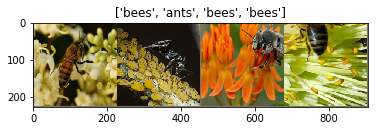

In [14]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

Now, let’s write a general function to train a model. Here, we will illustrate:

- Scheduling the learning rate
- Saving the best model

In the following, parameter `scheduler` is an LR scheduler object from `torch.optim.lr_scheduler`.

In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)
        
        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            
            # ----------
            #  Training
            # ----------
            if phase == "train":
                model.train() # set model to training mode
            else:
                model.eval() # set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # ---------
                #  Forward
                # ---------
                # Tracking history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimizer only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        
                # ------------
                #  Statistics
                # ------------
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == "train":
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print("{} loss: {:.4f}. Acc: {:.4f}".format(
                phase, epoch_loss, epoch_acc))
            
            # Deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
    
    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(
        time_elapsed // 60, time_elapsed % 60))
    print("Best Validation Acc: {:.4f}".format(best_acc))
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualizing the model predictions

Generic function to display predictions for a few images:

In [17]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["val"]):
            inputs = inputs.to(device)
            labels = inputs.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("Predicted: {}".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the convnet

Load a pretrained model and reset final fully connected layer:

In [18]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to 
# nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/dongdongdongdong/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 38.8MB/s]


## Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

In [21]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train loss: 0.6114. Acc: 0.6803
val loss: 0.2052. Acc: 0.9281

Epoch 1/9
----------
train loss: 0.4766. Acc: 0.7705
val loss: 0.1882. Acc: 0.9281

Epoch 2/9
----------
train loss: 0.4180. Acc: 0.7951
val loss: 0.4973. Acc: 0.8431

Epoch 3/9
----------
train loss: 0.4597. Acc: 0.8238
val loss: 0.2241. Acc: 0.9150

Epoch 4/9
----------
train loss: 0.4122. Acc: 0.8238
val loss: 0.2423. Acc: 0.9150

Epoch 5/9
----------
train loss: 0.4478. Acc: 0.8197
val loss: 0.2879. Acc: 0.8889

Epoch 6/9
----------
train loss: 0.6288. Acc: 0.7582
val loss: 0.4267. Acc: 0.8758

Epoch 7/9
----------
train loss: 0.4306. Acc: 0.8443
val loss: 0.3814. Acc: 0.8431

Epoch 8/9
----------
train loss: 0.2987. Acc: 0.8770
val loss: 0.2702. Acc: 0.8758

Epoch 9/9
----------
train loss: 0.3235. Acc: 0.8811
val loss: 0.2574. Acc: 0.8954

Training complete in 10m 38s
Best Validation Acc: 0.9281


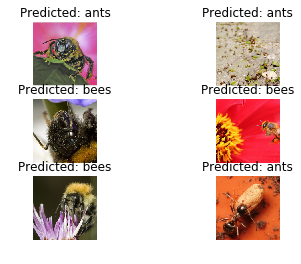

In [22]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need to set `requires_grad == False` to freeze the parameters so that the gradients are not computed in `backward()`.

You can read more about this in the documentation [here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward).

In [23]:
model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False
    
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

print(num_ftrs)

512


In [24]:
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = torch.optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Train and evaluate

On CPU this will take about half the time compared to previous scenario. This is expected as gradients don’t need to be computed for most of the network. However, forward does need to be computed.

In [25]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train loss: 0.7258. Acc: 0.5779
val loss: 0.3377. Acc: 0.8627

Epoch 1/9
----------
train loss: 0.5163. Acc: 0.7664
val loss: 0.2440. Acc: 0.9020

Epoch 2/9
----------
train loss: 0.5645. Acc: 0.7869
val loss: 0.2798. Acc: 0.8758

Epoch 3/9
----------
train loss: 0.4948. Acc: 0.8156
val loss: 0.2296. Acc: 0.9216

Epoch 4/9
----------
train loss: 0.3914. Acc: 0.8402
val loss: 0.2352. Acc: 0.9085

Epoch 5/9
----------
train loss: 0.4103. Acc: 0.8238
val loss: 0.1420. Acc: 0.9608

Epoch 6/9
----------
train loss: 0.5582. Acc: 0.7664
val loss: 0.1838. Acc: 0.9477

Epoch 7/9
----------
train loss: 0.3418. Acc: 0.8566
val loss: 0.1561. Acc: 0.9542

Epoch 8/9
----------
train loss: 0.4131. Acc: 0.8279
val loss: 0.1656. Acc: 0.9542

Epoch 9/9
----------
train loss: 0.2966. Acc: 0.8689
val loss: 0.1920. Acc: 0.9412

Training complete in 5m 1s
Best Validation Acc: 0.9608


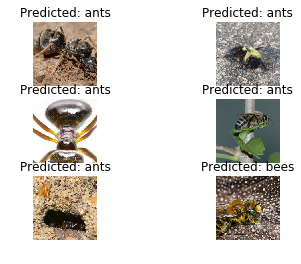

In [26]:
visualize_model(model_conv)

plt.ioff()
plt.show()